In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from redditqa.dataset import load_reddit_dataset
from dataclasses import dataclass, field
from typing import Optional
import huggingface_hub
import functools as ft
import torch
import pandas as pd
import torch
import os
from accelerate import Accelerator
from datasets import load_dataset
from peft import LoraConfig
from tqdm import tqdm
from transformers import Adafactor, AutoTokenizer, HfArgumentParser, pipeline, AutoConfig, GPTNeoXForCausalLM, AutoModelForCausalLM
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler
from transformers import pipeline, TextGenerationPipeline, AutoConfig, AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification, GPTNeoXForCausalLM, LlamaForSequenceClassification
from redditqa.dataset import load_reddit_dataset
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    set_peft_model_state_dict,
)
from peft.utils import _get_submodules
import peft
import torch
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats import inter_rater as irr

/home/jhoffbauer/reddit_qa/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-11 09:53:58.686260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 09:53:59.122355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Let's first load the dataset 

In [3]:
df = pd.read_csv('tmp/(23-08-08) Pairs for Labelling (250-1250) - Multi Annotated - Data.csv', header=[0, 1])


# Fix column names to have a single level
new_columns = [
    (c1 if not c1.startswith('Unnamed') else None, c2)
    for c1, c2 in df.columns.values
]

last_c1 = None
for i, (c1, c2) in enumerate(new_columns): 
    
    if c2 == 'Assignee': 
        last_c1 = None  
    elif c1 is None: 
        new_columns[i] = (last_c1, c2)
    else:
        last_c1 = c1
    
new_columns = [
    f'{c1} - {c2}' if c1 is not None else c2
    for c1, c2 in new_columns
]

df.columns = new_columns

df.head()

,Post ID,Pair ID,Question,Response J - Text,Response J - Score,Response J - Emotion,"Response J - Subjectivity [0, 1]",Response K - Text,Response K - Score,Response K - Emotion,"Response K - Subjectivity [0, 1]",Assignee,Label,Comment
0,6477or,6515193e8371d0c4c71c1b753b489d521943c49f6424fc...,Why is mass surveillance by the government on ...,The legal reason is because you do not have an...,27,NaN,0.25,What exactly do you mean by mass surveillance?...,3,😲,0.71,Tolga,2 - J is slightly better / unsure,NaN
1,29e2fn,c08ffa04985f2779f17d67a981ff249043ab1523ef7815...,Why do I feel more tired when I wake up early ...,Sleep works in different stages (like REM or d...,6,NaN,0.52,I take a lot if medications that make me tired...,1,NaN,0.70,Tolga,1 - J is better,NaN
2,20x5ha,5435dfe3489093d2f8598c68fc7286bb4de421fbfd235d...,If I am/my kids are vaccinated why should I be...,Because non-vaccinated children/people can hos...,3,NaN,0.00,"If you and your child are vaccinated with, say...",2,NaN,0.50,Tolga,1 - J is better,NaN
3,20gu9e,38133a7d8129d73504a64eb43916fbe8945ac93e77b856...,"What exactly is the issue with bees right now,...",The bees are infested with parasites. that's w...,2,🤢,0.49,I get that bees might be disappearing in the w...,-1,NaN,0.26,Tolga,1 - J is better,NaN
4,3l674c,a4546ef47c6ed8722f49962c014c67207df808a008bc3a...,Why do Chinese companies go to such lengths to...,Roadside car breakers in Ireland mis-spell the...,3,NaN,0.65,That reminds me. Years ago we bought a video g...,1,NaN,0.49,Tolga,4 - both are bad,NaN


#### Rows that we labelled 3 times 

Show how many unique labels we have per pair. Most pairs have more than two labels 

<Axes: >

(199, 15)

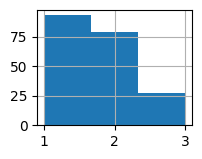

In [4]:
label_counts = df.groupby('Pair ID')['Label'].count()

# Bring label counts into df 
df['Pair Annotator Count'] = df['Pair ID'].map(label_counts)


display(
    df
        .query('`Pair Annotator Count` >= 3')
        .groupby('Pair ID')['Label'].agg('nunique').hist(bins=3, figsize=(2, 1.5))

)
df.query('`Pair Annotator Count` >= 3').drop_duplicates('Pair ID').shape

#### Labels and score difference 

Let's see if there is any correlation between the scores and the labels 

Per label, plot a histogram over the score difference

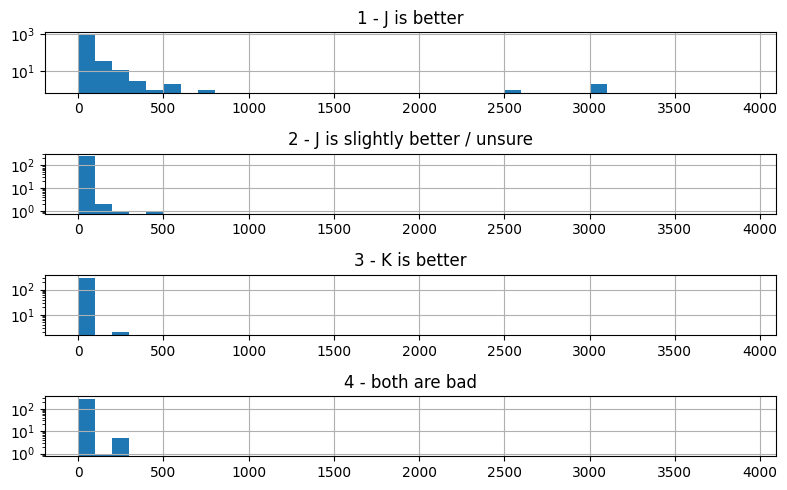

In [5]:
# df['Label Numerical'] = df['Label'].apply(lambda x: int(x[:1]) if isinstance(x, str) else x)

df['Score Difference'] = df['Response J - Score'] - df['Response K - Score']

# 4 histograms showing score distribution for every possble label
fig, axis = plt.subplots(4, 1, figsize=(8, 5))
for i, label in enumerate(sorted(list(df.Label.dropna().unique()))):
    df.query(f'Label == "{label}"')['Score Difference'].hist(ax=axis[i], bins=np.arange(0, 4000, 100), log=True)
    axis[i].set_title(label)
fig.tight_layout()

Per score difference, show the relative distribution of the labels. As reference also plot the absolute size of each bin below. 

It can be seen that "K is better" and "both are bad" are mostly correlated with lower scores but for "J is slightly better" no correlation can be found 

_This includes all labelled pairs, pairs labelled multiple times are included multiple times._

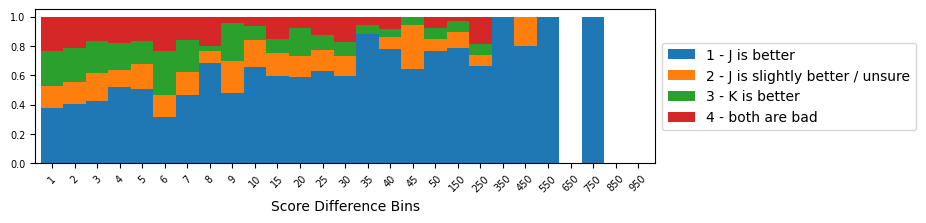

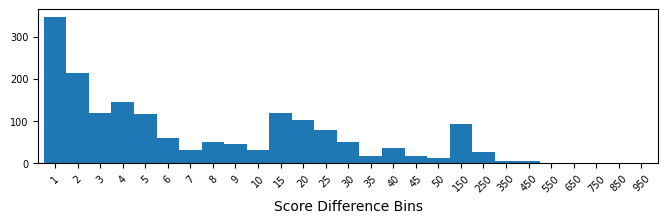

In [6]:
# Create bins for score differences 
bins = pd.cut(df['Score Difference'], bins=np.concatenate([
    np.arange(0, 10, 1), 
    np.arange(10, 50, 5), 
    np.arange(50, 1000, 100)
]))
bins = bins.apply(lambda x: f'{x.right}')
df['Score Difference Bins'] = bins

# Plot the distribution of score differences per label and counts 
plot_kwargs = {'kind': 'bar', 'figsize': (8, 2), 'rot': 45, 'width': 1.0}
df.groupby('Score Difference Bins')['Label'].value_counts(normalize=True).unstack().plot(**plot_kwargs, stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tick_params(axis='both', which='major', labelsize=7)
plt.show()
df.groupby('Score Difference Bins')['Label'].count().plot(**plot_kwargs, legend=False)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.show()

#### Inter Rater Agreement 

##### Labelled by 2 Annotators 

Calculate Cohen Kappa

In [7]:
# Calculate Kohen Kappa score for labelled pairs

double_labelled = df.query('`Pair Annotator Count` == 2').dropna(subset=['Label'])
double_labelled['Label'] = double_labelled['Label'].apply(lambda x: int(x[:1]))
double_labelled = double_labelled.groupby('Pair ID').agg({'Label': list})

# Unpack Label which is a list of two labels
double_labelled['Label1'] = double_labelled['Label'].apply(lambda x: x[0])
double_labelled['Label2'] = double_labelled['Label'].apply(lambda x: x[1])

cohen_kappa_score(
    y1=double_labelled['Label1'],
    y2=double_labelled['Label2'],
    labels=[1, 2, 3, 4],
)

0.3994257302067534

##### Labelled by 3 Annotators 

Calculate Fleiss' Kappa 

In [8]:
triple_labelled = df.query('`Pair Annotator Count` == 3').dropna(subset=['Label'])
triple_labelled['Label'] = triple_labelled['Label'].apply(lambda x: int(x[:1]))
triple_labelled = triple_labelled.groupby('Pair ID').agg({'Label': list})

num_labels = 4

def aggregate_raters(annotations): 
    """
    Convert list of annotations to array of counts where the index is the label and the value is the count
    """
    labels = [0] * 4

    for annotation in annotations:
        labels[annotation - 1] += 1

    return labels

triple_labelled['Label (Agg)'] = triple_labelled['Label'].apply(aggregate_raters)
aggregated_labels = np.array(triple_labelled['Label (Agg)'].to_list())

print(f"{irr.fleiss_kappa(aggregated_labels, method='fleiss')} on {aggregated_labels.shape[0]} samples")

0.37161769368988457 on 199 samples


#### Reward Model Accuracy by category 

##### Load and run reward model

In [9]:
reward_model_checkpoint = "/scratch1/jhoff/checkpoints/reward_llama-2-7b-chat-hf/checkpoint-3000_merged"

eval_dataset = load_reddit_dataset("eval", pairs=True)
eval_dataset = eval_dataset.shuffle(seed=42).select(range(1500))

tokenizer = AutoTokenizer.from_pretrained(reward_model_checkpoint)

reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_checkpoint, 
    num_labels=1, 
    torch_dtype=torch.bfloat16
)

reward_pipe = pipeline(
    "sentiment-analysis",
    model=reward_model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device=0,
)

template = "<|ELIF|> Question: %question\nAnswer: %answer"

def apply_reward_model(row):

    question_title = row["question_title"]
    response_j = row["response_j"]
    response_k = row["response_k"]

    qa_j = template.replace("%question", question_title).replace("%answer", response_j)
    reward_j = reward_pipe(qa_j)[0]["score"]

    qa_k = template.replace("%question", question_title).replace("%answer", response_k)
    reward_k = reward_pipe(qa_k)[0]["score"]

    return {
        'reward_j': float(reward_j),
        'reward_k': float(reward_k),
    }

eval_dataset = eval_dataset.map(apply_reward_model)

eval_dataset[0]

Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-cba55e4212677d14.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-d8898fc7c787d1eb.arrow
Loading cached shuffled indices for dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-e35089f0b695ca2b.arrow
Loading cached shuffled indices for dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-ea21b592f4358562.arrow
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it]
Parameter 'function'=<function apply_reward_model at 0x7f15ec972cb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is onl

{'answer_link_id': '2y0dxt',
 'question_title': 'Why do employers ask "where do you see yourself in 5-10 years?" How do personal goals matter at all?',
 'response_j': 'After you respond, be sure to ask, "How do you see the company changing over that timespan?"',
 'response_k': "Whatever job you're applying for, think of the logical career path and where you should be in fifteen years. Like all basic interview questions it's more about whether you can have an adult conversation than the actual answers. ",
 'score_j': 13,
 'score_k': 2,
 'reward_j': 0.8872045874595642,
 'reward_k': 0.8568122982978821}

##### Merge reward model results into dataframe

In [24]:
def get_row(question, response_j, response_k):
    result = eval_dataset\
        .filter(lambda x: x['question_title'] == question)\
        .filter(lambda x: x['response_j'] == response_j)\
        .filter(lambda x: x['response_k'] == response_k)

    if len(result) == 0: 
        return {}

    result = result[0]

    return {
        'Response J - Reward': result['reward_j'],
        'Response K - Reward': result['reward_k'],
    }

df_rewards = df.apply(lambda row: get_row(row['Question'], row['Response J - Text'], row['Response K - Text']), axis=1)
df_rewards = pd.DataFrame.from_records(df_rewards)

df_rewards['Selection'] = df_rewards.apply(lambda row: 'J' if row['Response J - Reward'] > row['Response K - Reward'] else 'K', axis=1)

Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-69c4071a81e9e34a.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-7dbe40a70671e97f.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-f2c0d35200387179.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-2822d11f64f6cdec.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-9abbca3805018fb1.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-f77e776e9c029b01.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-863590c6b408dc29.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-b4399b14e6e47569.arrow
Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-2489cde6bf776900.arrow
Loading cached processed dat

In [25]:
df = df.merge(df_rewards, left_index=True, right_index=True)

In [28]:
df.head(5)

,Post ID,Pair ID,Question,Response J - Text,Response J - Score,Response J - Emotion,"Response J - Subjectivity [0, 1]",Response K - Text,Response K - Score,Response K - Emotion,"Response K - Subjectivity [0, 1]",Assignee,Label,Comment,Pair Annotator Count,Score Difference,Score Difference Bins,Response J - Reward,Response K - Reward,Selection
0,6477or,6515193e8371d0c4c71c1b753b489d521943c49f6424fc...,Why is mass surveillance by the government on ...,The legal reason is because you do not have an...,27,NaN,0.25,What exactly do you mean by mass surveillance?...,3,😲,0.71,Tolga,2 - J is slightly better / unsure,NaN,3,24,25,0.853913,0.846958,J
1,29e2fn,c08ffa04985f2779f17d67a981ff249043ab1523ef7815...,Why do I feel more tired when I wake up early ...,Sleep works in different stages (like REM or d...,6,NaN,0.52,I take a lot if medications that make me tired...,1,NaN,0.70,Tolga,1 - J is better,NaN,3,5,5,0.934395,0.704160,J
2,20x5ha,5435dfe3489093d2f8598c68fc7286bb4de421fbfd235d...,If I am/my kids are vaccinated why should I be...,Because non-vaccinated children/people can hos...,3,NaN,0.00,"If you and your child are vaccinated with, say...",2,NaN,0.50,Tolga,1 - J is better,NaN,3,1,1,0.905990,0.896251,J
3,20gu9e,38133a7d8129d73504a64eb43916fbe8945ac93e77b856...,"What exactly is the issue with bees right now,...",The bees are infested with parasites. that's w...,2,🤢,0.49,I get that bees might be disappearing in the w...,-1,NaN,0.26,Tolga,1 - J is better,NaN,3,3,3,0.723310,0.570331,J
4,3l674c,a4546ef47c6ed8722f49962c014c67207df808a008bc3a...,Why do Chinese companies go to such lengths to...,Roadside car breakers in Ireland mis-spell the...,3,NaN,0.65,That reminds me. Years ago we bought a video g...,1,NaN,0.49,Tolga,4 - both are bad,NaN,3,2,2,0.782663,0.852935,K


In [35]:
accuracy_per_label = df.groupby('Label')['Selection'].value_counts(normalize=True).reset_index().query('Selection == "J"')
accuracy_per_label['Accuracy'] = (accuracy_per_label['proportion'] * 100).astype(str).str[:5] + '%'
accuracy_per_label = accuracy_per_label[['Label', 'Accuracy']]
accuracy_per_label

,Label,Accuracy
0,1 - J is better,81.22%
2,2 - J is slightly better / unsure,55.55%
5,3 - K is better,34.88%
6,4 - both are bad,60.07%
